In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from community_simulator.usertools import (MakeConsumerDynamics, MakeResourceDynamics,  MakeParams,
                                           MakeMatrices, MakeInitialState, a_default)
from community_simulator import Community
from community_simulator.visualization import PlotTraj, StackPlot
import pickle
from biom import Table, load_table
from scipy.spatial.distance import pdist, squareform
from skbio.stats.ordination import pcoa
%matplotlib inline

In [2]:
np.random.seed(1)
assumptions=a_default.copy() #Start with default parameters
assumptions['n_wells'] = 100 #Add more wells
assumptions['l'] = 0.8 #Assign a high leakage fraction to allow for a lot of crossfeeding
R0_food = np.linspace(30,300,assumptions['n_wells']) #Make a gradient of food supply levels
assumptions['R0_food'] = R0_food
assumptions['SA'] = 2 * np.ones(2)
assumptions['Sgen'] = 1
assumptions['S'] = 5

mp = {
    'regulation' : 'independent',
    'supply': 'external',
    'response': 'type I'
}

def dNdt(N, R, params):
    return MakeConsumerDynamics(mp)(N, R, params)

def dRdt(N, R, params):
    return MakeResourceDynamics(mp)(N, R, params)

dynamics = [dNdt, dRdt]

#Make initial state
init_state = MakeInitialState(assumptions)

#Make parameters
params = MakeParams(assumptions)

In [3]:
len(params)

100

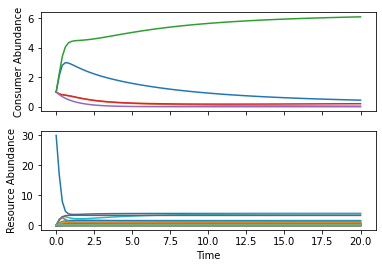

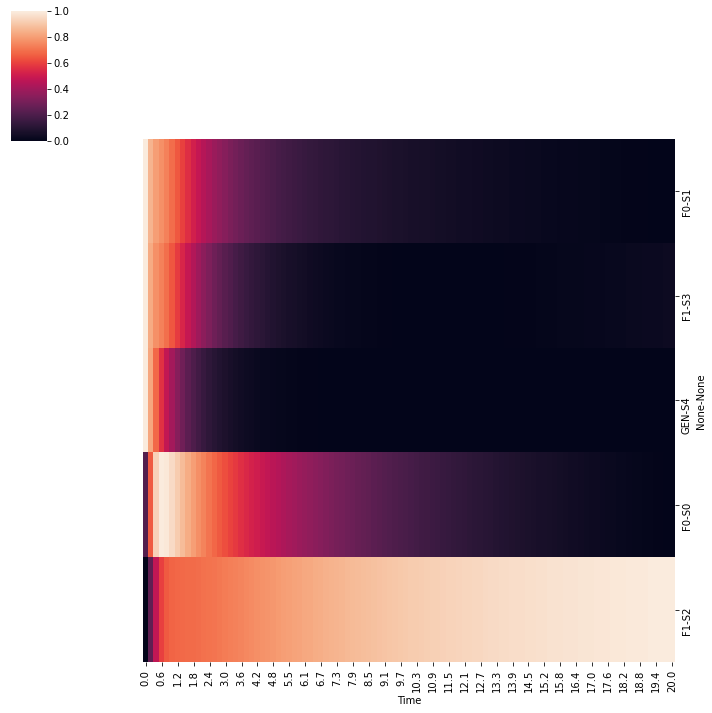

In [4]:
#Initialize plate
#(parallel=False ensures that tutorial will run on Windows.
#If you are running on Mac or Linux, set parallel=True to speed up)
test_colony = Community(init_state,dynamics,params,parallel=True)
out = test_colony.TestWell(T = 20)

Ntraj = pd.DataFrame(out[1],index = pd.Series(np.around(out[0],decimals=1),name='Time'),
                     columns = test_colony.N.index).T
Ntraj = Ntraj.loc[Ntraj.T.max()>0.01]
t_max = np.argmax(Ntraj.values,axis=1)
Ntraj['t_max'] = t_max
Ntraj = Ntraj.sort_values('t_max')
del Ntraj['t_max']
sns.clustermap(Ntraj,col_cluster=False,row_cluster=False,standard_scale=0)
plt.show()

In [22]:
resN, resR = [], []
test_colony2 = Community(init_state,dynamics,params,parallel=False)
for i, t in enumerate(np.linspace(0, 10)):
    test_colony2.Propagate(T=t)
    N = test_colony2.N.T
    R = test_colony2.R.T
    N['time'] = t
    R['time'] = t
    N['round'] = i
    R['round'] = i
    N = N.reset_index()
    N = N.set_index(['index', 'time', 'round'])
    R = R.reset_index()
    R = R.set_index(['index', 'time', 'round'])
    resN.append(N)
    resR.append(R)

In [23]:
resN = pd.concat(resN, axis=0)
resR = pd.concat(resR, axis=0)
resN.to_csv('data/N.txt', sep='\t')
resR.to_csv('data/R.txt', sep='\t')

In [24]:
D = pd.DataFrame(params[0]['D'], index=resR.columns, columns=resR.columns)
D.to_csv('data/D.txt', sep='\t')

In [25]:
C = pd.DataFrame(params[0]['c'], index=resN.columns, columns=resR.columns)
C.to_csv('data/C.txt', sep='\t')

In [30]:
resN

F0                    F1                 GEN
                         S0         S1         S2        S3        S4
index time round                                                     
W0    0.0  0       1.000000   1.000000   1.000000  1.000000  1.000000
W1    0.0  0       1.000000   1.000000   1.000000  1.000000  1.000000
W2    0.0  0       1.000000   1.000000   1.000000  1.000000  1.000000
W3    0.0  0       1.000000   1.000000   1.000000  1.000000  1.000000
W4    0.0  0       1.000000   1.000000   1.000000  1.000000  1.000000
...                     ...        ...        ...       ...       ...
W95   10.0 49     14.613751  11.846385  64.219262  7.173266  2.593082
W96   10.0 49     14.764053  11.974765  64.833470  7.248301  2.631209
W97   10.0 49     14.914349  12.103143  65.447684  7.323341  2.669338
W98   10.0 49     15.064641  12.231520  66.061903  7.398387  2.707468
W99   10.0 49     15.214928  12.359895  66.676128  7.473439  2.745599

[5000 rows x 5 columns]

In [29]:
resN.loc[(slice('W0'), slice(None), slice(None)), :]

UnsortedIndexError: 'MultiIndex slicing requires the index to be lexsorted: slicing on levels [0], lexsort depth 0'

F0                       F1                 GEN
                         S0            S1         S2        S3        S4
index time round                                                        
W0    10.0 49      0.083165  1.448879e-10   6.421820  0.272634  0.000000
W1    10.0 49      0.244995  4.188282e-06   7.012047  0.408669  0.000000
W2    10.0 49      0.408243  1.107236e-02   7.602418  0.537081  0.000000
W3    10.0 49      0.582618  1.391582e-01   8.177630  0.580163  0.000000
W4    10.0 49      0.755662  2.805459e-01   8.754588  0.617327  0.000000
...                     ...           ...        ...       ...       ...
W95   10.0 49     14.613751  1.184639e+01  64.219262  7.173266  2.593082
W96   10.0 49     14.764053  1.197476e+01  64.833470  7.248301  2.631209
W97   10.0 49     14.914349  1.210314e+01  65.447684  7.323341  2.669338
W98   10.0 49     15.064641  1.223152e+01  66.061903  7.398387  2.707468
W99   10.0 49     15.214928  1.235989e+01  66.676128  7.473439  2.745599

[100 rows x 5 columns]